# Data Challenge - Advanced Machine Learning


**The data challenge is proposed by Idemia**

## Description of the data challenge

You have at your disposal 100000 images of human faces, and their occlusion label.
The goal of this challenge is to regress the percentage of the face that is occluded.
We also want to have similar performances on female and male, the gender label is given for the train database.

Below is the formula of the evaluation score. You'll first need to compute the error made by your model for men and women separetely. The error is measured as follows

$$
 Err = \frac{\sum_{i}{w_i(p_i - GT_i)^2}}{\sum_{i}{w_i}}, w_i = \frac{1}{30} + GT_i,
$$
where $GT_i$ is the ground truth and p_i the prediction made by your model. 

Then, the final score for the leaderboard is given by

$$
Score = \frac{Err_F + Err_M}{2} + \left | Err_F - Err_M \right |,
$$
where $Err_F$ and $Err_M$ are the errors obtained for female and men, respectively.

Hereafter we show you how to load the data and run a naive baseline using a pretrained model.

### Downloading the Data:

You can download the Dataset from the below links: https://partage.imt.fr/index.php/s/mscQABX4oZxx7ax

In [1]:
# Import required libraries to run the naive baseline
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import OrderedDict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v3_small

d:\python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\python\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


### Load dataframes

In [2]:
df_train = pd.read_csv("listes_training/data_100K/train_100K.csv", delimiter=' ')
df_test = pd.read_csv("listes_training/data_100K/test_students.csv", delimiter=' ')

image_dir = "crops_100K"

In [3]:
df_train.head()

,filename,FaceOcclusion,gender
0,database1/img00011271.jpg,0.019,0.999
1,database1/img00012471.jpg,0.035,1.000
2,database1/img00008127.jpg,0.127,0.001
3,database1/img00008972.jpg,0.014,0.999
4,database1/img00028187.jpg,0.346,0.982


In [4]:
df_test.head()

,filename
0,database2/database2/test/0.jpg
1,database2/database2/test/1.jpg
2,database2/database2/test/2.jpg
3,database2/database2/test/3.jpg
4,database2/database2/test/4.jpg


#### Remove nan values

In [5]:
df_train = df_train.dropna()
df_test = df_test.dropna()

### Split Dataframe in train and val

In [6]:
df_val = df_train.loc[:20000].reset_index()
df_train = df_train.loc[20000:].reset_index()

In [7]:
len(df_train), len(df_val), len(df_test)

(81341, 20001, 30507)

### Check that all images are read correctly

In [8]:
for idx, row in tqdm(df_train.iterrows(), total=len(df_train)):
    try:
        filename = df_train.loc[idx, 'filename']
        img2display = Image.open(f"{image_dir}/{filename}")
    except ValueError as e:
        print(idx, e)
        
for idx, row in tqdm(df_test.iterrows(), total=len(df_test)):
    try:
        filename = df_test.loc[idx, 'filename']
        img2display = Image.open(f"{image_dir}/{filename}")
    except ValueError as e:
        print(idx, e)

100%|██████████| 30507/30507 [00:09<00:00, 3170.60it/s]


### Display first images

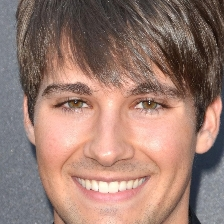

database1/img00013741.jpg 0.275 0.997


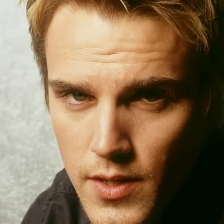

database1/img00006703.jpg 0.041 0.998


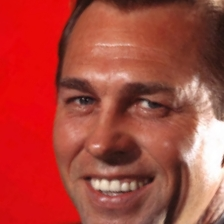

database1/img00004500.jpg 0.013 0.997


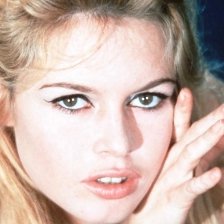

database1/img00021309.jpg 0.192 0.001


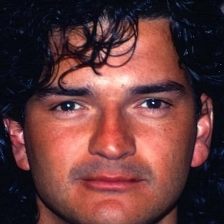

database1/img00007281.jpg 0.183 0.999


In [9]:
for idx, row in df_train[:5].iterrows():
    filename = row['filename']
    occlusion = row['FaceOcclusion']
    gender = row['gender']
    img2display = Image.open(f"{image_dir}/{filename}")
    display(img2display)
    print(filename, occlusion, gender)

### Make Dataset and Dataloader

In [10]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")
        y = row['FaceOcclusion']
        gender = row['gender']

        X = self.transform(img)
        y = np.float32(y)

        return X, y, gender, filename

In [11]:
training_set = Dataset(df_train, image_dir)
validation_set = Dataset(df_val, image_dir)

params_train = {'batch_size': 8,
          'shuffle': True,
          'num_workers': 0}

params_val = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

training_generator = torch.utils.data.DataLoader(training_set, **params_train)
validation_generator = torch.utils.data.DataLoader(validation_set, **params_val)

### Create naive model

In [12]:
'''
model = torchvision.models.mobilenet_v3_small(num_classes=1)
if torch.cuda.is_available():
    model.cuda()    
model
'''

'\nmodel = torchvision.models.mobilenet_v3_small(num_classes=1)\nif torch.cuda.is_available():\n    model.cuda()    \nmodel\n'

### Loss and optimizer

In [15]:
loss_fn = nn.MSELoss()

### Train naive model

In [16]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

#### Fit on train split

In [31]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
'''
# Load pre-trained ResNet and modify it
# Load pre-trained ResNet and modify it for regression
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 200 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')
'''


# 加载预训练的EfficientNet
model = models.efficientnet_b0(pretrained=True)
if torch.cuda.is_available():
    model.cuda()
    
# 修改最后的全连接层
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 1)

# 将模型移动到GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')


d:\python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 12.2MB/s]


Epoch 1/10


  0%|          | 1/10168 [00:00<2:10:25,  1.30it/s]

Batch 0, Loss: 0.10234725475311279


 20%|█▉        | 2001/10168 [18:36<1:16:07,  1.79it/s]

Batch 2000, Loss: 0.003472698386758566


 39%|███▉      | 4001/10168 [37:08<57:13,  1.80it/s]  

Batch 4000, Loss: 0.0015604656655341387


 59%|█████▉    | 6001/10168 [55:51<39:26,  1.76it/s]

Batch 6000, Loss: 0.000655911338981241


 79%|███████▊  | 8001/10168 [1:14:46<20:33,  1.76it/s]

Batch 8000, Loss: 0.0012264479883015156


 98%|█████████▊| 10001/10168 [1:33:53<01:36,  1.74it/s]

Batch 10000, Loss: 0.0014469736488536


100%|██████████| 10168/10168 [1:35:29<00:00,  1.77it/s]


Epoch [1/10], Loss: 0.0034152295421473054
Epoch 2/10


  0%|          | 1/10168 [00:00<1:44:58,  1.61it/s]

Batch 0, Loss: 0.001450209179893136


 20%|█▉        | 2001/10168 [19:24<1:18:41,  1.73it/s]

Batch 2000, Loss: 0.0005423991242423654


 39%|███▉      | 4001/10168 [39:01<1:00:39,  1.69it/s]

Batch 4000, Loss: 0.0007642112905159593


 59%|█████▉    | 6001/10168 [58:35<41:11,  1.69it/s]  

Batch 6000, Loss: 0.000551937788259238


 79%|███████▊  | 8001/10168 [1:18:22<21:46,  1.66it/s]

Batch 8000, Loss: 0.0001416858722222969


 98%|█████████▊| 10001/10168 [1:38:28<01:40,  1.66it/s]

Batch 10000, Loss: 0.00010987269342876971


100%|██████████| 10168/10168 [1:40:09<00:00,  1.69it/s]


Epoch [2/10], Loss: 0.0008987306400449934
Epoch 3/10


  0%|          | 1/10168 [00:00<1:41:31,  1.67it/s]

Batch 0, Loss: 0.00031537353061139584


 20%|█▉        | 2001/10168 [20:04<1:21:55,  1.66it/s]

Batch 2000, Loss: 0.0002775484463199973


 39%|███▉      | 4001/10168 [40:09<1:01:22,  1.67it/s]

Batch 4000, Loss: 0.0006648976705037057


 59%|█████▉    | 6001/10168 [1:00:18<42:03,  1.65it/s]

Batch 6000, Loss: 0.0015422208234667778


 79%|███████▊  | 8001/10168 [1:20:28<21:49,  1.65it/s]

Batch 8000, Loss: 0.0004022469511255622


 98%|█████████▊| 10001/10168 [1:40:40<01:41,  1.64it/s]

Batch 10000, Loss: 0.0003121504560112953


100%|██████████| 10168/10168 [1:42:21<00:00,  1.66it/s]


Epoch [3/10], Loss: 0.0006882225682017099
Epoch 4/10


  0%|          | 1/10168 [00:00<1:42:59,  1.65it/s]

Batch 0, Loss: 0.00019278824038337916


 20%|█▉        | 2001/10168 [19:57<1:21:14,  1.68it/s]

Batch 2000, Loss: 0.00015734441694803536


 39%|███▉      | 4001/10168 [39:57<1:01:50,  1.66it/s]

Batch 4000, Loss: 0.0004939574282616377


 59%|█████▉    | 6001/10168 [59:59<41:38,  1.67it/s]  

Batch 6000, Loss: 9.806320304051042e-05


 79%|███████▊  | 8001/10168 [1:20:02<21:41,  1.66it/s]

Batch 8000, Loss: 0.0001767962530720979


 98%|█████████▊| 10001/10168 [1:40:05<01:40,  1.66it/s]

Batch 10000, Loss: 0.00026000101934187114


100%|██████████| 10168/10168 [1:41:45<00:00,  1.67it/s]


Epoch [4/10], Loss: 0.0005578031072178007
Epoch 5/10


  0%|          | 1/10168 [00:00<1:44:42,  1.62it/s]

Batch 0, Loss: 0.0005593248642981052


 20%|█▉        | 2001/10168 [20:14<1:23:26,  1.63it/s]

Batch 2000, Loss: 0.0006645849207416177


 39%|███▉      | 4001/10168 [40:38<1:02:47,  1.64it/s]

Batch 4000, Loss: 0.0004386245273053646


 59%|█████▉    | 6001/10168 [1:00:57<42:06,  1.65it/s]

Batch 6000, Loss: 0.0004103579558432102


 79%|███████▊  | 8001/10168 [1:21:15<21:50,  1.65it/s]

Batch 8000, Loss: 0.0002453019260428846


 98%|█████████▊| 10001/10168 [1:41:30<01:40,  1.66it/s]

Batch 10000, Loss: 0.00043206452392041683


100%|██████████| 10168/10168 [1:43:12<00:00,  1.64it/s]


Epoch [5/10], Loss: 0.0004795016408687801
Epoch 6/10


  0%|          | 1/10168 [00:00<1:44:30,  1.62it/s]

Batch 0, Loss: 0.00020172586664557457


 20%|█▉        | 2001/10168 [19:56<1:21:00,  1.68it/s]

Batch 2000, Loss: 0.00022198131773620844


 39%|███▉      | 4001/10168 [39:50<1:00:51,  1.69it/s]

Batch 4000, Loss: 0.00017574275261722505


 59%|█████▉    | 6001/10168 [59:43<41:03,  1.69it/s]  

Batch 6000, Loss: 0.0020930704195052385


 79%|███████▊  | 8001/10168 [1:19:32<21:38,  1.67it/s]

Batch 8000, Loss: 0.00029552384512498975


 98%|█████████▊| 10001/10168 [1:39:22<01:39,  1.68it/s]

Batch 10000, Loss: 0.0003220438666176051


100%|██████████| 10168/10168 [1:41:02<00:00,  1.68it/s]


Epoch [6/10], Loss: 0.0004095532223606805
Epoch 7/10


  0%|          | 1/10168 [00:00<1:43:33,  1.64it/s]

Batch 0, Loss: 0.00013977279013488442


 20%|█▉        | 2001/10168 [19:46<1:21:01,  1.68it/s]

Batch 2000, Loss: 0.00038187429890967906


 39%|███▉      | 4001/10168 [39:33<1:00:33,  1.70it/s]

Batch 4000, Loss: 0.0006238111527636647


 59%|█████▉    | 6001/10168 [59:16<40:27,  1.72it/s]  

Batch 6000, Loss: 0.0002796977059915662


 79%|███████▊  | 8001/10168 [1:18:52<21:13,  1.70it/s]

Batch 8000, Loss: 5.3177565860096365e-05


 98%|█████████▊| 10001/10168 [1:38:28<01:38,  1.70it/s]

Batch 10000, Loss: 0.00011983964941464365


100%|██████████| 10168/10168 [1:40:06<00:00,  1.69it/s]


Epoch [7/10], Loss: 0.00036268957361957314
Epoch 8/10


  0%|          | 1/10168 [00:00<1:41:22,  1.67it/s]

Batch 0, Loss: 0.00013065220264252275


 20%|█▉        | 2001/10168 [22:30<1:35:55,  1.42it/s]

Batch 2000, Loss: 0.0003076410503126681


 39%|███▉      | 4001/10168 [44:28<1:11:43,  1.43it/s]

Batch 4000, Loss: 0.0005996697000227869


 59%|█████▉    | 6001/10168 [1:07:50<48:27,  1.43it/s]

Batch 6000, Loss: 0.00022030988475307822


 79%|███████▊  | 8001/10168 [1:31:09<25:23,  1.42it/s]

Batch 8000, Loss: 0.001014887704513967


 98%|█████████▊| 10001/10168 [1:54:29<01:57,  1.42it/s]

Batch 10000, Loss: 0.000185575510840863


100%|██████████| 10168/10168 [1:56:25<00:00,  1.46it/s]


Epoch [8/10], Loss: 0.0003224234352638152
Epoch 9/10


  0%|          | 1/10168 [00:00<2:00:05,  1.41it/s]

Batch 0, Loss: 0.00028104946250095963


 20%|█▉        | 2001/10168 [23:19<1:35:22,  1.43it/s]

Batch 2000, Loss: 0.0002938731340691447


 39%|███▉      | 4001/10168 [46:35<1:11:44,  1.43it/s]

Batch 4000, Loss: 0.0002282285422552377


 59%|█████▉    | 6001/10168 [1:07:23<41:30,  1.67it/s]

Batch 6000, Loss: 0.000543809961527586


 79%|███████▊  | 8001/10168 [1:27:20<21:42,  1.66it/s]

Batch 8000, Loss: 0.0005480382824316621


 98%|█████████▊| 10001/10168 [1:47:21<01:39,  1.68it/s]

Batch 10000, Loss: 0.00047571142204105854


100%|██████████| 10168/10168 [1:49:01<00:00,  1.55it/s]


Epoch [9/10], Loss: 0.0002902878896314369
Epoch 10/10


  0%|          | 1/10168 [00:00<1:47:08,  1.58it/s]

Batch 0, Loss: 0.0001201322374981828


 20%|█▉        | 2001/10168 [19:53<1:20:29,  1.69it/s]

Batch 2000, Loss: 4.4855583837488666e-05


 39%|███▉      | 4001/10168 [39:45<1:00:58,  1.69it/s]

Batch 4000, Loss: 0.0001923648378578946


 59%|█████▉    | 6001/10168 [59:35<40:49,  1.70it/s]  

Batch 6000, Loss: 2.3257483917404898e-05


 79%|███████▊  | 8001/10168 [1:19:14<21:29,  1.68it/s]

Batch 8000, Loss: 0.0002840402303263545


 98%|█████████▊| 10001/10168 [1:38:57<01:38,  1.69it/s]

Batch 10000, Loss: 0.0034769815392792225


100%|██████████| 10168/10168 [1:40:36<00:00,  1.68it/s]

Epoch [10/10], Loss: 0.0002691591896770827
Training complete


In [18]:
num_epochs = 5
'''
for n in range(num_epochs):
    print(f"Epoch {n}")
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        # Transfer to GPU
        X, y = X.to(device), y.to(device)
        y = torch.reshape(y, (len(y), 1))
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        if loss.isnan():
            print(filename)
            print('label', y)
            print('y_pred', y_pred)
            break

        if batch_idx % 200 == 0:
            print(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
'''

Epoch 0


  0%|          | 0/10168 [00:00<?, ?it/s]

  0%|          | 0/10168 [00:00<?, ?it/s]


NameError: name 'model' is not defined

## Evaluate metric on validation split

In [32]:
def error_fn(df):
    pred = df.loc[:, "pred"]
    ground_truth = df.loc[:, "target"]
    weight = 1/30 + ground_truth

    return np.sum(((pred - ground_truth)**2) * weight, axis=0) / np.sum(weight, axis=0)

def metric_fn(female, male):
    err_male = error_fn(male)
    err_female = error_fn(female)
    return (err_male + err_female) / 2 + abs(err_male - err_female)

In [33]:
results_list = []
for batch_idx, (X, y, gender, filename) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        for i in range(len(X)):

            results_list.append({'pred': float(y_pred[i]),
                                  'target': float(y[i]),
                                  'gender': float(gender[i])
                                 })
results_df = pd.DataFrame(results_list)

100%|██████████| 2501/2501 [10:36<00:00,  3.93it/s]


In [34]:
results_df.head()

,pred,target,gender
0,0.022896,0.019,0.999
1,0.030522,0.035,1.000
2,0.125973,0.127,0.001
3,0.019250,0.014,0.999
4,0.339735,0.346,0.982


<Axes: >

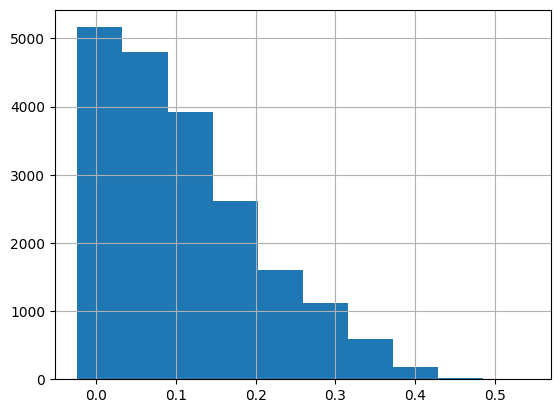

In [35]:
results_df['pred'].hist()

In [36]:
results_male = results_df.loc[results_df["gender"] > 0.5]
results_female = results_df.loc[results_df["gender"] < 0.5]
print(results_male)
print(results_female)


           pred  target  gender
0      0.022896   0.019   0.999
1      0.030522   0.035   1.000
3      0.019250   0.014   0.999
4      0.339735   0.346   0.982
6      0.273560   0.268   0.999
...         ...     ...     ...
19992  0.005339   0.007   1.000
19993  0.008217   0.010   0.999
19996  0.047250   0.071   0.999
19999  0.035239   0.029   0.998
20000  0.279828   0.275   0.997

[7276 rows x 3 columns]
           pred  target  gender
2      0.125973   0.127   0.001
5      0.034153   0.043   0.000
7      0.105622   0.113   0.002
9      0.119395   0.105   0.002
10     0.086626   0.086   0.002
...         ...     ...     ...
19991  0.175111   0.225   0.000
19994  0.361435   0.376   0.001
19995  0.050655   0.063   0.002
19997  0.017041   0.022   0.003
19998  0.123427   0.131   0.001

[12725 rows x 3 columns]


In [37]:
metric_fn(results_male, results_female)

0.0010618406238302978

## Evaluating your Test DataSet

In [38]:
class Dataset_test(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")

        X = self.transform(img)

        return X, filename

In [39]:
test_set = Dataset_test(df_test, image_dir)

params_test = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

test_generator = torch.utils.data.DataLoader(test_set, **params_test)

In [40]:
results_list = []
for batch_idx, (X, filename) in tqdm(enumerate(test_generator), total=len(test_generator)):
        X = X.to(device)
        y_pred = model(X)
        for i in range(len(X)):

            results_list.append({'pred': float(y_pred[i])
                                 })
test_df = pd.DataFrame(results_list)

100%|██████████| 3814/3814 [15:30<00:00,  4.10it/s]


In [41]:
test_df.head()

,pred
0,0.294524
1,0.325527
2,0.354262
3,0.304066
4,0.367186


### Preparing your file for Submission

In [42]:
test_df.to_csv("Data_Challenge.csv", header = None, index = None)

#### Now it's your turn. Good luck !  :) 